# Paddle2.0-通过LSGAN让我们看看AI预测的外星人长什么样子

**先看看生成效果：**


![](https://ai-studio-static-online.cdn.bcebos.com/438b037522e34dfeb968ee7fe74fb8fedda60ebb35e642dabe5d29d35a5298ee)

 - 本项目将通过爬取外星人矢量图，训练一个生成对抗网络（GAN）来产生新的外星人。为了节省时间，请尽量选择GPU进行训练。
 - 本项目的综合应用请见项目：**星际终端**

## 2 参数设置及数据集准备

### 2.1 爬取外星人图片

 - 从百度爬取关键词为“外星人 矢量”的图片。直接用“外星人”为关键词的图片感觉风格太乱了，不好训练。
 
  - 爬虫代码源自最早的项目，可以爬取任意数量，任意关键词图片，训练利器：[Paddle2.0+ imgaug数据增广,新年“集福”示例,年年都有无尽的福](http://https://aistudio.baidu.com/aistudio/projectdetail/1537167?shared=1) 

In [1]:
import requests
import re
import os
import time

##
def client():
    global search_words
    global pages
    global end_pages
    global start_pages
    search_words = '外星人 矢量'
    start_pages = 1 ##看我们要下多少页的数据
    end_pages = 60

        
#图片爬取函数
def Pictures_Crawling(indexName=True):
    index=100000
    !mkdir pic/
    for page in range(start_pages,end_pages):
        url = 'https://image.baidu.com/search/flip?tn=baiduimage&ie=utf-8&word={}&pn={}'.format(search_words, page)
        #url = 'https://image.baidu.com/search/index?tn=baiduimage&ipn=r&ct=201326592&cl=2&lm=-1&st=-1&fm=result&fr=&sf=1&fmq=1600582955784_R&pv=&ic=0&nc=1&z=&hd=&latest=&copyright=&se=1&showtab=0&fb=0&width=&height=&face=0&istype=2&ie=utf-8&sid=&word=%E9%81%93%E8%B7%AF%E7%A6%81%E6%AD%A2%E8%B7%AF%E6%A0%87'
        #伪装浏览器请求头
        headers={
            'user-agent': 'Mozilla / 5.0(Windows NT 10.0;Win64;x64) AppleWebKit / 537.36(KHTML, like Gecko) Chrome / 84.0 .4147.89Safari / 537.36'
                }
        
        #获取网站源码
        html = requests.get(url,headers=headers)
        #获取真实的url
        urls_real = re.findall('"thumbURL":"(.*?)",', html.text)
        print('图片url数量',len(urls_real))
        #print(urls_real)
        #筛选资源url，并返回元组
        #urls = re.findall(r'<img alt="" src="(http://.*?.jpg)" ',html.text)
        #资源存放文件夹路径
        root = 'pic/'
        #print(urls_real)
        for i in urls_real :
            subname=i.split('/')[-1]#资源存放名称 eg:'u=4117662774,1210746205&fm=193'
            if indexName:
                filename=str(index)+'.png'
                index+=1
            else:
                try:
                    check=re.findall(r"=(.+?)&",subname)
                    if len(check)==0:
                        filename=subname
                    else:
                        filename=re.findall(r"=(.+?)&",subname)[0].replace(',','')+'.png'
                except Exception as e:
                    
                    print(e)
                    print (subname)
                    filename=str(time.time())+'.png'
            path = root + filename #资源存放点+资源存放名称
            #print(path)
            #i='https:\\/\\/ns-strategy.cdn.bcebos.com\\/ns-strategy\\/upload\\/fc_big_pic\\/part-00094-2012.jpg'
            if '\\/' in i:
                print('ii',i)
                i=i.replace('\\','')
                print('ii',i)
            #print(i)
                
            image_data = requests.get(i,headers=headers)
            with open(path, 'wb')as f:  #将图片以二进制写入
                f.write(image_data.content)
            #print('save ',path,i)
    print('total index',index)       
runpic=False
#没有图片文件夹就取爬图片
if not os.path.exists('pic') or runpic:
    !mkdir pic/
    client()
    Pictures_Crawling()

### 2.2 定义Config参数

定义训练参数，并写入到txt中，以备后续翻查。


**设置的超参数为：**

 * 学习率：0.0001
 * 输入图片长和宽：128
 * Epoch: 1000
 * Mini-Batch：32
 * 输入Tensor长度：100
 * Adam：Beta1：0.5，Beta2：0.999  

In [3]:
import json
import os
configPath='configs/'
if not os.path.exists(configPath):
    !mkdir configs/
path=configPath+'config0720.txt'
##
dictObj={
    'img_dim':128,
    'lr': 0.0001,
    'epoch':  1000,
    'output':"Output/",
    'batch_size': 32,
    'G_DIMENSION': 100,
    'beta1':0.5,
    'beta2':0.999,
    'output_path': 'Output'
}
##
jsObj = json.dumps(dictObj, indent=4)  # indent参数是换行和缩进
with open(path,'w') as f:
    f.write(jsObj) 
##
with open(path) as f:
    config = json.load(f)
    print(config)


{'img_dim': 128, 'lr': 5e-05, 'epoch': 10000, 'output': 'Output/', 'batch_size': 32, 'G_DIMENSION': 100, 'beta1': 0.5, 'beta2': 0.999, 'output_path': 'Output'}


### 2.3 数据集预处理
多线程处理，以裁切坐标(0,0)和(128,128)，将输入网络的图片裁切到128*128.用多线程处理

In [4]:
from PIL import Image
import os.path
import os
import threading
import paddle
from PIL import ImageFile
print(paddle.__version__)
ImageFile.LOAD_TRUNCATED_IMAGES = True

'''多线程将图片缩放后再裁切到128*128分辨率'''
#裁切图片宽度
# w = 512
#裁切图片高度
# h = 512
ww = config['img_dim']
hh =  config['img_dim']
#裁切点横坐标(以图片左上角为原点)
x = 0
#裁切点纵坐标
y = 0

def cutArray(l, num):
  avg = len(l) / float(num)
  o = []
  last = 0.0

  while last < len(l):
    o.append(l[int(last):int(last + avg)])
    last += avg

  return o
  
def convertjpg(jpgfile,outdir,width=ww,height=hh):
    img=Image.open(jpgfile)
    (l,h) = img.size
    rate = min(l,h) / width
    try:
        img = img.resize((int(l // rate),int(h // rate)),Image.BILINEAR)
        img = img.crop((x,y,width+x,height+y))
        img.save(os.path.join(outdir,os.path.basename(jpgfile)))
    except Exception as e:
        print(e)

class thread(threading.Thread):
    def __init__(self, threadID, inpath, outpath, files):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.inpath = inpath
        self.outpath = outpath
        self.files = files
    def run(self):
        count = 0
        try:
            for file in self.files:
                convertjpg(self.inpath + file,self.outpath)
                count = count + 1
        except Exception as e:
            print(e)
        print('已处理图片数量：' +  str(count))
            
if __name__ == '__main__':
    inpath = '/home/aistudio/pic/'
    outpath = '/home/aistudio/data/imgs/'
    
    if not os.path.exists(outpath):
        os.mkdir(outpath)
        files =  os.listdir(inpath)
        files = cutArray(files,8)
        T1 = thread(1, inpath, outpath, files[0])
        T2 = thread(2, inpath, outpath, files[1])
        T3 = thread(3, inpath, outpath, files[2])
        T4 = thread(4, inpath, outpath, files[3])
        T5 = thread(5, inpath, outpath, files[4])
        T6 = thread(6, inpath, outpath, files[5])
        T7 = thread(7, inpath, outpath, files[6])
        T8 = thread(8, inpath, outpath, files[7])
        
        T1.start()
        T2.start()
        T3.start()
        T4.start()
        T5.start()
        T6.start()
        T7.start()
        T8.start()
        
        T1.join()
        T2.join()
        T3.join()
        T4.join()
        T5.join()
        T6.join()
        T7.join()
        T8.join()


2.0.2
已处理图片数量：482
已处理图片数量：482
已处理图片数量：482
已处理图片数量：481
已处理图片数量：482
已处理图片数量：482
已处理图片数量：482
已处理图片数量：482


## 3 模型组网

### 3.1 定义数据预处理工具-Paddle.io.Dataset
具体参考[Paddle.io.Dataset教程](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-rc/api/paddle/io/Dataset_cn.html#dataset)

In [5]:
import os
import cv2
import numpy as np
# from skimage import io,color,transform
import matplotlib.pyplot as plt
import math
import time
import paddle
from paddle.io import Dataset
import six
from PIL import Image 
import paddle.fluid as fluid
from paddle.static import InputSpec
paddle.enable_static()
# img_dim = 512
img_dim = config['img_dim']


'''准备数据，定义Reader()'''
PATH = '/home/aistudio/data/imgs/'

class DataGenerater(Dataset):
    """
    数据集定义
    """
    def __init__(self,path=PATH):
        """
        构造函数
        """
        super(DataGenerater, self).__init__()
        self.dir = path
        self.datalist = os.listdir(PATH)
        self.image_size = (img_dim,img_dim)
    
    # 每次迭代时返回数据和对应的标签
    def __getitem__(self, idx):
        return self._load_img(self.dir + self.datalist[idx])

    # 返回整个数据集的总数
    def __len__(self):
        return len(self.datalist)
    
    def _load_img(self, path):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        try:
            img = cv2.imread(path)[:,:,:3]
            img = cv2.resize(img,self.image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #mg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            # img_norm = np.zeros(img.shape)
            # img = cv2.normalize(img, dst=img_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            img = np.array(img).astype('float32') # 转换成数组类型浮点型32位
            img = img.transpose() # 矩阵转置
            # print(img)
            img = img/255.0
        except Exception as e:
                print(e)
        return img

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
2021-07-28 10:44:13,084 - INFO - font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/co

(128, 128, 3)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


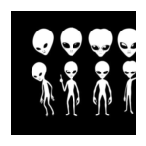

In [6]:
# CV2读入图片后为BGR模式，而plt画图则是RGB模式，这就导致图片颜色发生很大变化
# 故采用cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)将读入的BGR图片转换为RGB图片
img_BGR = cv2.imread("/home/aistudio/data/imgs/100001.png")[:,:,:3]
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
# p = Image.open("work/imgs/kanasi_female_vcg_raw_page4_30.jpg")
print(img_RGB.shape)
image = np.array(img_RGB)
plt.figure(figsize=(25,25))
plt.subplot(10, 10,  1)
plt.imshow(image, vmin=-1, vmax=1)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
plt.close()

### 3.2 测试Paddle.io.DataLoader并输出图片

In [7]:
train_dataset = DataGenerater()
imgs = paddle.static.data(name='img', shape=[None,3,img_dim,img_dim], dtype='float32')
print(imgs)

var img : paddle.VarType.LOD_TENSOR.shape(-1, 3, 128, 128).astype(VarType.FP32)


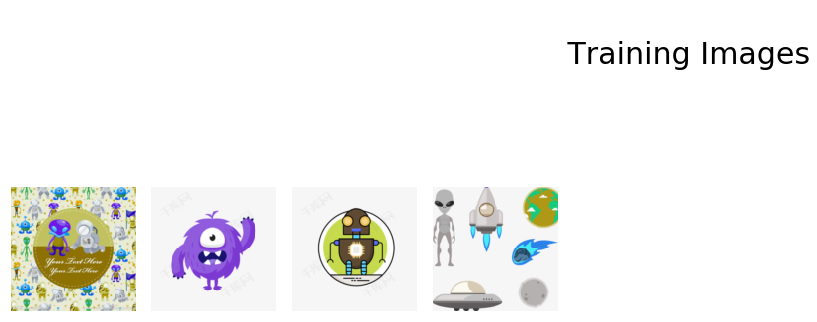

In [8]:

train_loader = paddle.io.DataLoader(
    train_dataset, 
    places=paddle.CPUPlace(), 
    feed_list = [imgs],
    batch_size=config['batch_size'], 
    shuffle=True,
    num_workers=2,
    use_buffer_reader=True,
    use_shared_memory=False,
    # drop_last (bool) - 是否丢弃因数据集样本数不能被 batch_size 整除而产生的最后一个不完整的mini-batch，为 batch_sampler 的替代参数
    drop_last=True,
    )

for batch_id, data in enumerate(train_loader()):
    plt.figure(figsize=(25,25))
    try:
        for i in range(4):
            # 1,3,512,512 -> 512,512,3
            image = np.array(data[0][i])[0].transpose((2,1,0))
            image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            plt.subplot(10, 10, i + 1)
            plt.imshow(image, vmin=-1, vmax=1)
            plt.axis('off')
            plt.xticks([])
            plt.yticks([])
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.suptitle('\n Training Images',fontsize=30)
        plt.show()
        break
    except IOError:
        print(IOError)


### 3.3 权重初始化
参考在 DCGAN 论文中，作者指定所有模型权重应从均值为0、标准差为0.02的正态分布中随机初始化。  
在paddle.nn中，调用fluid.nn.initializer.Normal实现initialize设置

In [9]:
conv_initializer=paddle.nn.initializer.Normal(mean=0.0, std=0.02)
bn_initializer=paddle.nn.initializer.Normal(mean=1.0, std=0.02)


### 3.4 判别器
如上文所述，生成器$D$是一个二进制分类网络，它以图像作为输入，输出图像是真实的（相对应$G$生成的假样本）的概率。输入$Shape$为[3,128,128]的RGB图像，通过一系列的$Conv2d$，$BatchNorm2d$和$LeakyReLU$层对其进行处理，然后通过全连接层输出的神经元个数为2，对应两个标签的预测概率。

* 将BatchNorm批归一化中momentum参数设置为0.5
* 将判别器(D)激活函数leaky_relu的alpha参数设置为0.2

> 输入:  为大小128*128的RGB三通道图片  
> 输出:  经过一层全连接层最后为shape为[batch_size,2]的Tensor

In [10]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
img_dim=config['img_dim']
class Discriminator(paddle.nn.Layer):
    def __init__(self,img_dim=img_dim):
        super(Discriminator, self).__init__()
        # class paddle.nn.Conv2D(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', weight_attr=None, bias_attr=None, data_format='NCHW')
        # 在判别器中第一层卷积和第二层卷积之间不需要用batchNorm
        # 3*512*512
        self.conv_1 = nn.Conv2D(
            3,64,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_1_",initializer=conv_initializer)
            )
        # 64*256*256
        self.conv_2 = nn.Conv2D(
            64,img_dim,4,2,1,
            #64,128,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_2_",initializer=conv_initializer)
            )
        self.bn_2 = nn.BatchNorm2D(
            img_dim,
            #128，
            weight_attr=paddle.ParamAttr(name="d_2_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 128*128*128
        self.conv_3 = nn.Conv2D(
            #128,256,4,2,1,
            img_dim,256,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_3_",initializer=conv_initializer)
            )
        self.bn_3 = nn.BatchNorm2D(
            256,
            weight_attr=paddle.ParamAttr(name="d_3_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 256*64*64
        self.conv_4 = nn.Conv2D(
            256,512,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_4_",initializer=conv_initializer)
            )
        self.bn_4 = nn.BatchNorm2D(
            512,
            weight_attr=paddle.ParamAttr(name="d_4_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        self.conv_5 = nn.Conv2D(
            512,1024,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_5_",initializer=conv_initializer)
            )
        self.bn_5 = nn.BatchNorm2D(
            1024,
            weight_attr=paddle.ParamAttr(name="d_5_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        self.conv_6 = nn.Conv2D(
            1024,1,4,1,0,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="d_conv_weight_6_",initializer=conv_initializer)
        )
        # 1*1*1
    
    def forward(self, x):
        x = self.conv_1(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv_5(x)
        x = self.bn_5(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv_6(x)
        return x

# 采用LSGAN
去掉判别器网络的sigmoid函数

### 3.5 生成器
生成器$G$旨在映射潜在空间矢量$z$到数据空间。由于我们的数据是图像，因此转换$z$到数据空间意味着最终创建具有与训练图像相同大小[3,128,128]的RGB图像。在网络设计中，这是通过一系列二维卷积转置层来完成的，每个层都与$BatchNorm$层和$ReLu$激活函数。生成器的输出通过$tanh$函数输出，以使其返回到输入数据范围[−1,1]。值得注意的是，在卷积转置层之后存在$BatchNorm$函数，因为这是DCGAN论文的关键改进。这些层有助于训练过程中的梯度更好地流动。  

* 将$BatchNorm$批归一化中$momentum$参数设置为0.5

> 输入:Tensor的Shape为[batch_size,100]其中每个数值大小为0~1之间的float32随机数  
> 输出:3x128*128RGB三通道图片


In [11]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
try:
    G_DIMENSION=config['G_DIMENSION']
except:
    G_DIMENSION=100
class Generator(paddle.nn.Layer):
    def __init__(self,G_DIMENSION=G_DIMENSION):
        super(Generator, self).__init__()
        self.conv_1 = nn.Conv2DTranspose(
            #100,1024,4,1,0,
            G_DIMENSION,1024,4,1,0,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_1_",initializer=conv_initializer)
            )
        self.bn_1 = nn.BatchNorm2D(
            1024,
            weight_attr=paddle.ParamAttr(name="g_1_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 512 * 32 * 32
        self.conv_2 = nn.Conv2DTranspose(
            1024,512,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_2_",initializer=conv_initializer)
            )
        self.bn_2 = nn.BatchNorm2D(
            512,
            weight_attr=paddle.ParamAttr(name="g_2_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 256 * 64 * 64
        self.conv_3 = nn.Conv2DTranspose(
            512,256,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_3_",initializer=conv_initializer)
            )
        self.bn_3 = nn.BatchNorm2D(
            256,
            weight_attr=paddle.ParamAttr(name="g_3_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 128 * 128 * 128
        self.conv_4 = nn.Conv2DTranspose(
            256,128,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_4_",initializer=conv_initializer)
            )
        self.bn_4 = nn.BatchNorm2D(
            128,
            weight_attr=paddle.ParamAttr(name="g_4_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        self.conv_5 = nn.Conv2DTranspose(
            128,64,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_5_",initializer=conv_initializer)
            )
        self.bn_5 = nn.BatchNorm2D(
            64,
            weight_attr=paddle.ParamAttr(name="g_5_bn_weight_",initializer=bn_initializer),momentum=0.8
            )
        # 64 * 256 * 256
        self.conv_6 = nn.Conv2DTranspose(
            64,3,4,2,1,
            bias_attr=False,weight_attr=paddle.ParamAttr(name="g_dconv_weight_6_",initializer=conv_initializer)
            )
        # 3 * 64 * 64
        self.tanh = paddle.nn.Tanh()
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = F.relu(x)
        x = self.conv_5(x)
        x = self.bn_5(x)
        x = F.relu(x)
        x = self.conv_6(x)
        print('conv_6',x.shape)
        x = self.tanh(x)
        return x

### 3.6 损失函数
选用BCELoss,公式如下:

  $Out = -1 * (label * log(input) + (1 - label) * log(1 - input))$
 
 LSGAN将BCELoss改成MSELoss

In [12]:
###损失函数
# loss = paddle.nn.BCELoss()
# 改为
loss = paddle.nn.MSELoss()

## 4 模型训练
 
训练过程中的每一次迭代，生成器和判别器分别设置自己的迭代次数。为了避免判别器快速收敛到0，本教程默认每迭代一次，训练 1次判别器，4次生成器。

In [ ]:
import IPython.display as display
import warnings
from visualdl import LogWriter
import paddle.optimizer as optim
warnings.filterwarnings('ignore')

#vdl_train=LogWriter('vdl_dygraph/train')

# img_dim = 512
img_dim = config['img_dim']
lr =config['lr']
epoch = config['epoch']
output = config['output']
batch_size = config['batch_size']
G_DIMENSION = config['G_DIMENSION']
beta1 = config['beta1']
beta2 = config['beta2']
output_path = config['output_path']
#device = paddle.set_device('gpu')
paddle.disable_static()

real_label = 1.
fake_label = 0.

netD = Discriminator()
netG = Generator()
optimizerD = optim.Adam(parameters=netD.parameters(), learning_rate=lr, beta1=beta1, beta2=beta2)
optimizerG = optim.Adam(parameters=netG.parameters(), learning_rate=lr, beta1=beta1, beta2=beta2)
##
state_dict = paddle.load("/home/aistudio/work/generator072502.params")
netG.set_state_dict(state_dict)
###训练过程
losses = [[], []]
#plt.ion()
now = 0
for pass_id in range(epoch):
    # enumerate()函数将一个可遍历的数据对象组合成一个序列列表
    for batch_id, data in enumerate(train_loader()):
        #训练判别器 
        optimizerD.clear_grad()
        real_cpu = data[0]
        label = paddle.full((batch_size,1,1,1),real_label,dtype='float32')
        output = netD(real_cpu)
        errD_real = loss(output,label)
        errD_real.backward()
        optimizerD.step()
        optimizerD.clear_grad()

        noise = paddle.randn([batch_size,G_DIMENSION,1,1],'float32')
        fake = netG(noise)
        label = paddle.full((batch_size,1,1,1),fake_label,dtype='float32')
        output = netD(fake.detach())
        errD_fake = loss(output,label)
        errD_fake.backward()
        optimizerD.step()
        optimizerD.clear_grad()

        errD = errD_real + errD_fake
        
        losses[0].append(errD.numpy()[0])
        ###训练生成器
        optimizerG.clear_grad()
        noise = paddle.randn([batch_size,G_DIMENSION,1,1],'float32')
        fake = netG(noise)
        label = paddle.full((batch_size,1,1,1),real_label,dtype=np.float32,)
        output = netD(fake)
        errG = loss(output,label)
        errG.backward()
        optimizerG.step()
        optimizerG.clear_grad()
        ###训练生成器
        optimizerG.clear_grad()
        noise = paddle.randn([batch_size,G_DIMENSION,1,1],'float32')
        fake = netG(noise)
        label = paddle.full((batch_size,1,1,1),real_label,dtype=np.float32,)
        output = netD(fake)
        errG = loss(output,label)
        errG.backward()
        optimizerG.step()
        optimizerG.clear_grad()
        ###训练生成器
        optimizerG.clear_grad()
        noise = paddle.randn([batch_size,G_DIMENSION,1,1],'float32')
        fake = netG(noise)
        label = paddle.full((batch_size,1,1,1),real_label,dtype=np.float32,)
        output = netD(fake)
        errG = loss(output,label)
        errG.backward()
        optimizerG.step()
        optimizerG.clear_grad()
        
        losses[1].append(errG.numpy()[0])
        if  batch_id % 400 == 0 or pass_id%400==0:
            
            paddle.save(netG.state_dict(), "/home/aistudio/checkpoint/generator"+str(pass_id)+".params")
        if batch_id % 400 == 0:
            
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            # 每轮的生成结果
            generated_image = netG(noise).numpy()
            ##
            #vdl_train.add_scalar(tag="train/D-loss", step=batch_id, value=errD.numpy()[0])
            #vdl_train.add_scalar(tag="train/G-Loss", step=batch_id, value=errG.numpy()[0])
            
            #vdl_train.add_image(tag="generated_image", img=generated_image,step=batch_id)
            ##
            imgs = []
            plt.figure(figsize=(25,25))
            try:
                for i in range(4):
                    image = generated_image[i].transpose()
                    image = np.where(image > 0, image, 0)
                    
                    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                    plt.subplot(10, 10, i + 1)
                    plt.imshow(image, vmin=-1, vmax=1)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(pass_id, batch_id, errD.numpy()[0], errG.numpy()[0])
                plt.suptitle(msg,fontsize=20)
                plt.draw()
                plt.savefig('{}/{:04d}_{:04d}.png'.format(output_path, pass_id, batch_id),bbox_inches='tight')
                plt.pause(0.01)
                display.clear_output(wait=True)
            except IOError:

                print(IOError)
    print("epoch:{}/{}".format(pass_id,epoch))

paddle.save(netG.state_dict(), "/home/aistudio/work/generator.params")

plt.close()


In [ ]:
plt.figure(figsize=(15, 6))
x = np.arange(len(losses[0]))
plt.title('Generator and Discriminator Loss During Training')
plt.xlabel('Number of Batch')
plt.plot(x,np.array(losses[0]),label='D Loss')
plt.plot(x,np.array(losses[1]),label='G Loss')
plt.legend()
plt.savefig('/home/aistudio/work/Generator and Discriminator Loss During Training.png')
plt.show()

In [ ]:

paddle.save(netG.state_dict(), "/home/aistudio/work/generator072502.params")

## 6 模型预测
### 输入随机数让生成器$G$生成随机风景图片
生成的RGB三通道128*128的图片路径位于“worl/Generate/”

In [ ]:
import paddle
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
##
conv_initializer=paddle.nn.initializer.Normal(mean=0.0, std=0.02)
bn_initializer=paddle.nn.initializer.Normal(mean=1.0, std=0.02)
##
device = paddle.set_device('gpu')
paddle.disable_static(device)
try:
    
    netG = Generator()
    state_dict = paddle.load("/home/aistudio/work/generator0725.params")
    netG.set_state_dict(state_dict)
    noise = paddle.randn([100,100,1,1],'float32')
    # generated_image = generate(noise).numpy()
    generated_image = netG(noise).numpy()
    imgs = []
    plt.figure(figsize=(25,25))
    for i in range(8):
        image = generated_image[i].transpose()
        image = np.where(image > 0, image, 0)
        plt.subplot(10, 10, i + 1)
        plt.imshow(image, vmin=-1, vmax=1)
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
    plt.savefig('generate072502.png',bbox_inches='tight')
    plt.pause(0.01)
    display.clear_output(wait=True)
except IOError:
    print(IOError)


In [ ]:
# !mv work/Generator\ and\ Discriminator\ Loss\ During\ Training.png Generator\ and\ Discriminator\ Loss\ During\ Training.png